# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**DOUBTS**
- Calcolare alpha e beta per ogni stazione con il fit di scipy? Vanno messe due nuove colonne nel dataset? Se c'è una sola osservazione non posso fare il fit => uniforme? (alpha=1, beta=1)
- Output: AMS o alpha e beta?
- Initial guess? 
- Alpha e beta predetti per ogni stazione come vanno paragonati con quelli "veri"? Intervallo di confidenza sulla media o sui parametri (questo come si calcola) ?
- Come si fa inferenza su più distribuzioni? Quali metriche?
- 20 epoche e 2 hidden impara come 2 epoche e 0 hidden

**TO DO**
- provare con solo MAP in input
- pca?
- nel test ogni stazione ha senso che ci sia una sola volta, tanto l'output sarà sempre lo stesso


# 0. Importing libraries

In [218]:
colab = False

In [219]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [220]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


from fitter import Fitter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

if colab:
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

# 1. Load and inspect the dataset

## 1.1. Load data

In [221]:
if colab:
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
    dataset_indexes_test = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"
    dataset_indexes_test = "data/gumMap_statbench_Gumfit_NEW.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)

df_indexes_test = pd.read_csv(dataset_indexes_test, sep=',', encoding='utf-8') #dataset used to extract the ids for test

print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [222]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [223]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


## 1.2. Preprocess and split the dataset

In [224]:
def scale_AMS(df, k = 1.5):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
    """

    min_AMS = df['AMS'].min() - 1e-3 # to avoid zero values
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [225]:
def standardize(df):
    
    features_not_to_scale = ['ID', 'AMS', 'mean_IdD', 'duration[h]']
    features_to_scale = df.columns.drop(features_not_to_scale)

    order_columns = ['ID', 'AMS', 'mean_IdD', 'duration[h]'] + list(features_to_scale)

    scaler = MinMaxScaler() #min max scaler to have values in range [0, 1]
    
    scaled_data = scaler.fit_transform(df[features_to_scale])
    non_scaled_data = df[features_not_to_scale]
    std_df = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_df = pd.DataFrame(std_df, columns=order_columns)

    # scale AMS
    std_df = scale_AMS(std_df)

    return std_df

### Split the dataset into train, validation and test

In [226]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]


test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

In [227]:
# Drop the test set from std_dfs and then create the train sets and validation sets

df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])
    
train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [228]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.250
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.680425,199.875
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.855535,199.875
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.945591,199.875
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,24,1.518449,199.875


### Standardize datasets

In [229]:
train_df_std = standardize(train_df)
val_df_std = standardize(val_df)
test_df_std = standardize(test_df)

In [230]:
# column id must be integer

train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

In [231]:
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [232]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.128797,28.250,1,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,5001,0.071421,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,5001,0.089999,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,5001,0.099553,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,5001,0.160329,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077


### Add the guesses to datasets

In [233]:
def add_alpha_beta(df):

    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan

    for id in df['ID'].unique():
        try:
            a, b, _, _ = stats.beta.fit(df[df['ID'] == id]['AMS'], floc=0, fscale=1)
        except:
            a, b = 1, 1
        
        df.loc[df['ID'] == id, 'alpha'] = a
        df.loc[df['ID'] == id, 'beta'] = b

    # if there are nan values, raise exception
    if df.isnull().values.any():
        raise Exception('There are nan values in the dataframe')

    return df

In [234]:
train_df_std = add_alpha_beta(train_df_std)
val_df_std = add_alpha_beta(val_df_std)
test_df_std = add_alpha_beta(test_df_std)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:783: RuntimeWarning: divide by zero encountered in scalar divide
  fac = xbar * (1 - xbar) / data.var(ddof=0) - 1
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:604: RuntimeWarning: invalid value encountered in scalar add
  func = [s1 - n * (-psiab + sc.psi(a)),
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:605: RuntimeWarning: invalid value encountered in scalar add
  s2 - n * (-psiab + sc.psi(b))]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:783: RuntimeWarning: divide by zero encountered in scalar divide
  fac = xbar * (1 - xbar) / data.var(ddof=0) - 1
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:604: RuntimeWarn

In [235]:
train_df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
0,5001,0.128797,28.250000,1,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,20.760776,176.330109
1,5001,0.071421,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,20.760776,176.330109
2,5001,0.089999,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,20.760776,176.330109
3,5001,0.099553,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,20.760776,176.330109
4,5001,0.160329,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,20.760776,176.330109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233213,20034,0.105024,27.678571,6,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,7.508771,65.033324
233214,20034,0.139618,19.800000,3,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,7.508771,65.033324
233215,20034,0.147119,19.800000,3,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,7.508771,65.033324
233216,20034,0.219214,12.635714,1,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,7.508771,65.033324


In [236]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.105325,57.052651,9.199200,0.166813,0.246883,0.322643,0.308758,0.546673,0.547496,...,0.314823,0.358757,0.272092,0.061749,0.309248,0.093732,0.480096,0.415496,8.219760,69.736103
std,4333.130131,0.039818,31.051531,8.280664,0.157116,0.200644,0.230440,0.194339,0.125339,0.156197,...,0.187693,0.195579,0.168673,0.128670,0.196419,0.148481,0.241816,0.233321,5.994949,50.952932
min,5001.000000,0.000106,5.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.752806,1.000000
25%,8094.000000,0.078451,34.984444,3.000000,0.049758,0.073997,0.104254,0.166739,0.472726,0.449271,...,0.168426,0.218142,0.139936,0.003447,0.150809,0.017792,0.260888,0.233598,5.992622,50.835128
50%,12005.000000,0.098034,49.674286,6.000000,0.120710,0.221548,0.329908,0.322565,0.546955,0.555668,...,0.289269,0.323356,0.232531,0.007566,0.264866,0.029456,0.517307,0.347570,7.620279,64.642368
75%,16065.000000,0.123545,70.343750,12.000000,0.239505,0.370564,0.483975,0.441252,0.625345,0.652737,...,0.435152,0.459347,0.369040,0.032635,0.433575,0.079028,0.668883,0.599175,9.560985,81.137528
max,20034.000000,0.666411,318.742857,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,374.311071,3179.544867


## 1.4. Prepare data for training

In [237]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'alpha', 'beta'],
      dtype='object')

In [238]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns =   ['alpha', 'beta'] #columns[3:-2]
output_column = 'AMS'
parameters_columns = ['alpha', 'beta']
print('Input columns: ', input_columns)

Input columns:  ['alpha', 'beta']


In [239]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [240]:
inputs_train

,alpha,beta
0,20.760776,176.330109
1,20.760776,176.330109
2,20.760776,176.330109
3,20.760776,176.330109
4,20.760776,176.330109
...,...,...
233213,7.508771,65.033324
233214,7.508771,65.033324
233215,7.508771,65.033324
233216,7.508771,65.033324


# 2. Model definition

#### Base model

In [241]:
def build_nn_beta_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        #x = layers.BatchNormalization()(x)
        
    alpha_beta = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=(1e-6)+tf.math.exp(t[:, 0:1]), concentration1=(1e-6)+tf.math.exp(t[:, 1:2]), validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

# 3. Metrics 

In [242]:
def sample_metrics(dist, y, label, color, plot = True):
    num_samples = 1
    y_pred = dist.sample(num_samples).numpy().ravel()
    
    mae = metrics.mean_absolute_error(y, y_pred)
    ks_statistics, _ = stats.ks_2samp(y, y_pred)

    if plot:
        plt.hist(y, bins='auto', alpha=0.7, label=label, density=True, color='green');
        #sns.kdeplot(y_pred, label='Estimated sample', fill=True)
        plt.hist(y_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color=color);
        plt.legend()
        plt.show()

    return mae, ks_statistics

def plot_series(data, labels=None, predictions=None, figsize=None, filled_version=None, std=None, ci=None, title=None, ylim=None):
    
    plt.figure(figsize=figsize)
    plt.plot(data.index, data.values, zorder=0)
    
    if filled_version is not None:
        filled = filled_version.copy()
        filled[~data['value'].isnull()] = np.nan
        plt.scatter(filled.index, filled, marker='.', c='tab:orange', s=5);
    
    # Plot standard deviations
    if std is not None:
        lb = data.values.ravel() - std.values.ravel()
        ub = data.values.ravel() + std.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='+/- std')
    
    # Plot confidence intervals
    if ci is not None:
        lb = ci[0].ravel()
        ub = ci[1].ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='C.I.')
    
    # Rotated x ticks
    plt.xticks(rotation=45)
    
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels], color='red', zorder=2, s=5)
    
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions], color='black', alpha=.4, zorder=3, s=5)
    
    # Force y limits
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.grid(linestyle=':')
    plt.title(title)
    plt.tight_layout()

def percentage_in_ci(inputs, y, dist, confidence, distribution = 'beta', start = None, end = None, plot = True, num_samples=1):
    
    if start is None:
        start = 0
    if end is None:
        end = len(y)

    if distribution == 'beta':
        lb, ub = stats.beta.interval(confidence, a=dist.concentration1, b=dist.concentration0)
        mean_dist = dist.mean().numpy().ravel()
        y_pred = dist.sample(num_samples).numpy().ravel()

        if plot:
            plot_series(pd.Series(index=inputs[start:end].index, data=mean_dist[start:end]), ci=(lb[start:end], ub[start:end]), figsize=(12,6))
            plt.scatter(inputs[start:end].index, y_pred[start:end], marker='o', color='blue', label='Predicted');
            plt.scatter(inputs[start:end].index, y[start:end], marker='x', color='red', label='True');
            plt.legend()
            plt.show()
    
        count_true = 0
        for i in range(len(y)):
            if lb[i] <= y[i] <= ub[i]:
                count_true += 1
        
        true_guess = count_true/len(y)*100

        return true_guess

# 4. Training

In [243]:
def train_nn_model(model, X, y, batch_size, loss, lr, verbose=0, patience=10, validation_data=None, **fit_params):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    
    # Build the early stop callback
    cb = []
    if validation_data is not None:
        cb += [callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
    
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, callbacks=cb, validation_data=validation_data, verbose=verbose, **fit_params)
    
    return history

def plot_training_history(history=None, figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

# Duration 3 

## Training

In [244]:
X_train = inputs_train.values
y_train  = outputs_train.values
X_val = inputs_val.values
y_val = outputs_val.values
X_test = inputs_test.values
y_test = outputs_test.values

In [245]:
# Parameters for the training
batch_size = 64
epochs = 20
lr = 1e-3
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

print('Training the model without the guesses...')
model = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=[128, 64])
history = train_nn_model(model, X_train, y_train, batch_size, loss_prof, lr, verbose=1, patience=10, validation_data=(X_val, y_val), epochs=epochs)
plot_training_history(history, figsize=(14, 4))

Training the model without the guesses...
Epoch 1/20


 441/3645 [==>...........................] - ETA: 5s - loss: 2743.0464

InvalidArgumentError: Graph execution error:

Detected at node model_5/distribution_lambda_5/Beta/assert_positive/assert_less/Assert/AssertGuard/Assert defined at (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/73/q15nk7zj12b12wgzsnb2wkwm0000gn/T/ipykernel_1160/2993897294.py", line 9, in <module>

  File "/var/folders/73/q15nk7zj12b12wgzsnb2wkwm0000gn/T/ipykernel_1160/1623167948.py", line 11, in train_nn_model

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 220, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 226, in call

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/lambda_layer.py", line 212, in call

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 166, in _fn

  File "/var/folders/73/q15nk7zj12b12wgzsnb2wkwm0000gn/T/ipykernel_1160/1888064317.py", line 11, in <lambda>

  File "/Users/niccolomarzi/Library/Python/3.9/lib/python/site-packages/decorator.py", line 232, in fun

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 342, in wrapped_init

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/distributions/beta.py", line 189, in __init__

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 603, in __init__

  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/distributions/beta.py", line 413, in _parameter_control_dependencies

assertion failed: [Concentration parameter must be positive..  ] [Condition x > 0 did not hold element-wise:] [x (model_5/distribution_lambda_5/add:0) = ] [[-nan][-nan][-nan]...]
	 [[{{node model_5/distribution_lambda_5/Beta/assert_positive/assert_less/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_280336]

* Train evaluation

Evaluating the models on training set...


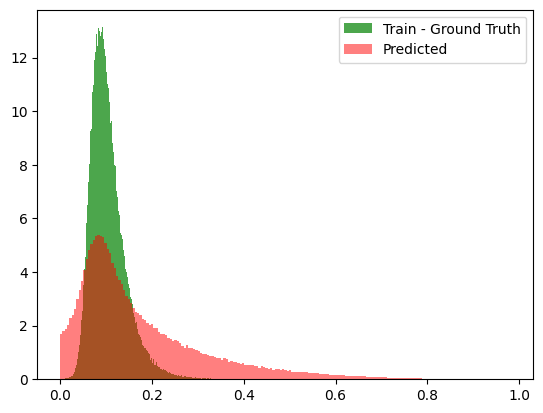

Train:
MAE: 0.11
KS statistics: 0.32


In [212]:
print('Evaluating the models on training set...')

dist_train = model(X_train)
mae_train, ks_statist_train = sample_metrics(dist_train, y_train, 'Train - Ground Truth', 'red')
print('Train:')
print(f'MAE: {mae_train:.2f}')
print(f'KS statistics: {ks_statist_train:.2f}')

# Store the results in a dataframe
results = pd.DataFrame(columns=['Split', 'MAE', 'KS statistics'])

train_no_guess = ['Train', mae_train, ks_statist_train]
results.loc[0] = train_no_guess

* Validation evaluation

Evaluating the models on validation set...


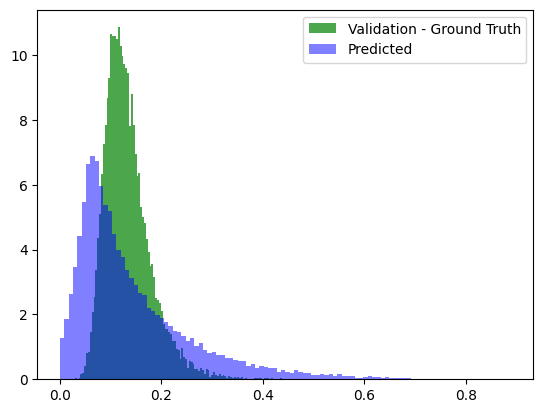

Validation:
MAE: 0.09
KS statistics: 0.28


In [213]:
print('Evaluating the models on validation set...')

dist_val = model(X_val)
mae_val, ks_statist_val = sample_metrics(dist_val, y_val, 'Validation - Ground Truth', 'blue')
print('Validation:')
print(f'MAE: {mae_val:.2f}')
print(f'KS statistics: {ks_statist_val:.2f}')

val_no_guess = ['Validation', mae_val, ks_statist_val]
results.loc[1] = val_no_guess

## Evaluation and predictions on test set

Evaluating the models on test set...


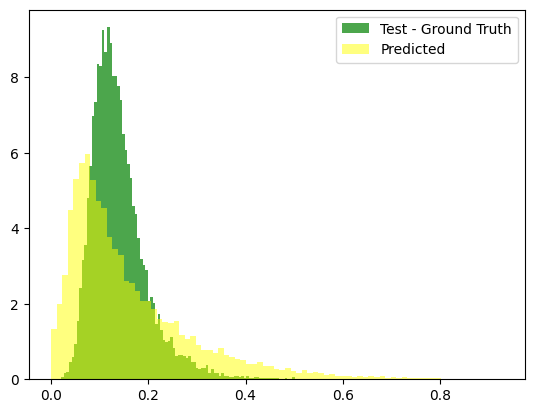

Test:
MAE: 0.10
KS statistics: 0.21


In [214]:
print('Evaluating the models on test set...')

dist_test = model(X_test)
mae_test, ks_statist_test = sample_metrics(dist_test, y_test, 'Test - Ground Truth', 'yellow')
print('Test:')
print(f'MAE: {mae_test:.2f}')
print(f'KS statistics: {ks_statist_test:.2f}')

test_no_guess = ['Test', mae_test, ks_statist_test]
results.loc[2] = test_no_guess

In [215]:
display(results)

,Split,MAE,KS statistics
0,Train,0.109731,0.317686
1,Validation,0.092126,0.282010
2,Test,0.103252,0.214077


* Distribution mean - confidence interval 

Evaluation based on confidence intervals..


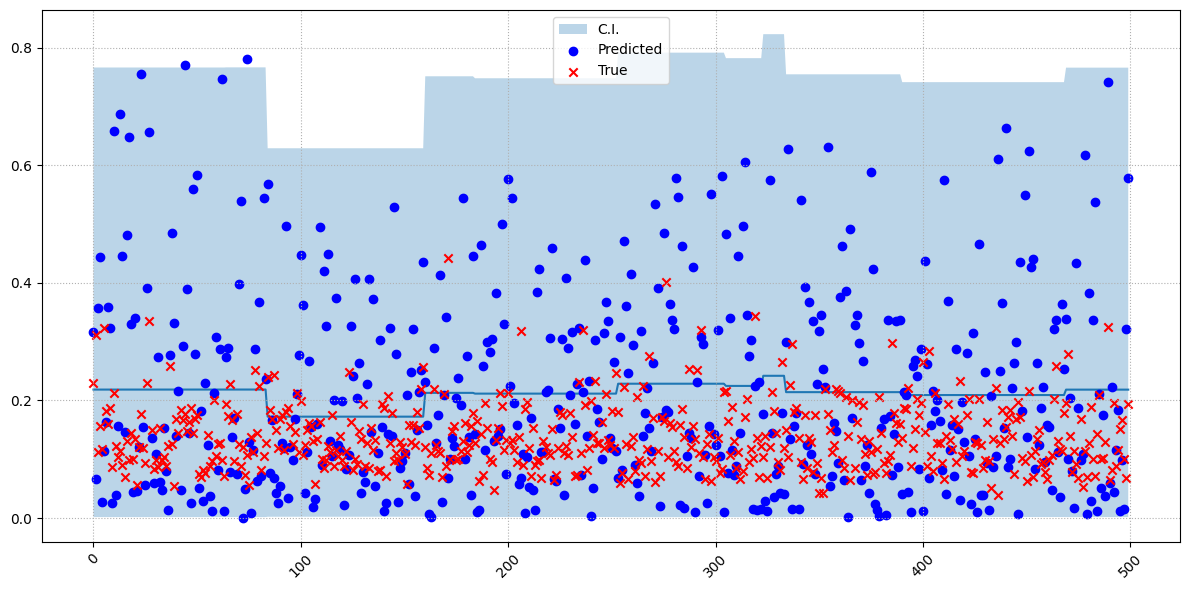

Percentage of values inside the 99% confidence interval: 95.20%


In [216]:
confidence = 0.99

print('Evaluation based on confidence intervals..')

inside = percentage_in_ci(inputs_test, y_test, dist_test, confidence, end = 500)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

### Parameters

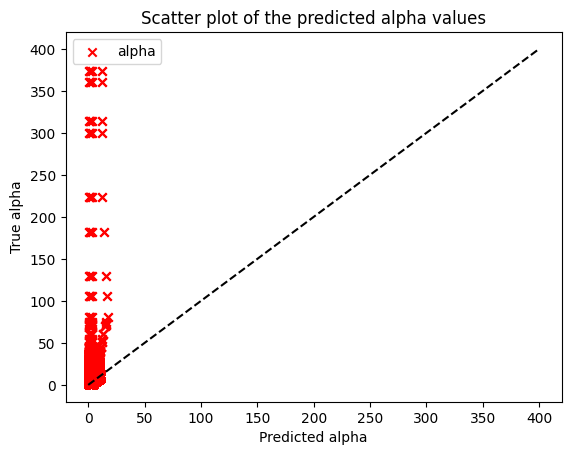

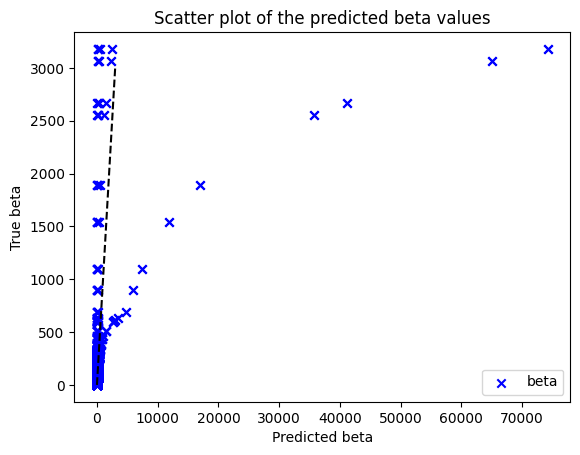

In [217]:
a_pred = dist_train.concentration1.numpy()
b_pred = dist_train.concentration0.numpy()

# scatter plot of the predicted alpha values
plt.scatter(a_pred, parameters_train['alpha'], color='red', label='alpha', marker='x')
# add bisector line
x = np.linspace(0, 400, 100)
plt.plot(x, x, color='black', linestyle='--')
plt.xlabel('Predicted alpha')
plt.ylabel('True alpha')
plt.legend()
plt.title('Scatter plot of the predicted alpha values')
plt.show()

# scatter plot of the predicted beta values
plt.scatter(b_pred, parameters_train['beta'], color='blue', label='beta', marker='x')
# add bisector line
x = np.linspace(0, 3000, 100)
plt.plot(x, x, color='black', linestyle='--')
plt.xlabel('Predicted beta')
plt.ylabel('True beta')
plt.legend()
plt.title('Scatter plot of the predicted beta values')
plt.show()

* Comparison between two samples extracted from "true" and predicted distribution of the same place 

True alpha:  20.760775659343253 Predicted alpha:  8.104824
True beta:  176.3301091079855 Predicted beta:  65.98682


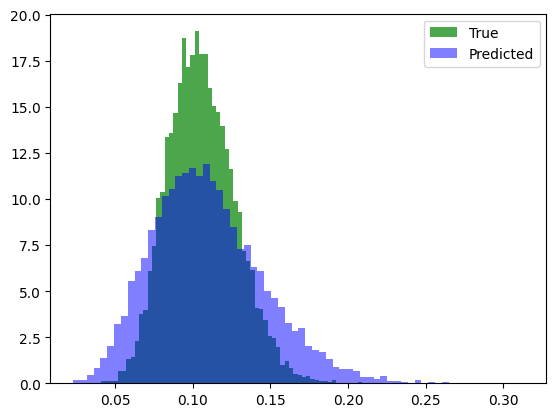

In [153]:
index = 1

a_pred = dist_train.concentration1.numpy().ravel()[index]
b_pred = dist_train.concentration0.numpy().ravel()[index]

a_true = parameters_train['alpha'][index]
b_true = parameters_train['beta'][index]

print('True alpha: ', a_true, 'Predicted alpha: ', a_pred)
print('True beta: ', b_true, 'Predicted beta: ', b_pred)

samples_pred = stats.beta.rvs(a=a_pred, b=b_pred, size=10000)
samples_true = stats.beta.rvs(a=a_true, b=b_true, size=10000)

plt.hist(samples_true, bins='auto', alpha=0.7, label='True', density=True, color='green');
plt.hist(samples_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color='blue');
plt.legend()
plt.show()

* Metrics for parameters

In [154]:
# calculate the biasr for the ALPHA parameter

a_true = parameters_test['alpha'].to_numpy()
a_pred = dist_test.concentration1.numpy().ravel()

# calculate the biasr
biasr = ((a_true - a_pred) / a_true).mean()
print(f'Biasr for the alpha parameter: {biasr:.2f}')

#rmse
rmse = metrics.mean_squared_error(a_true, a_pred, squared=False)
print(f'RMSE for the alpha parameter: {rmse:.2f}')

#pcc
pcc = np.corrcoef(a_true, a_pred)[0, 1]
print(f'PCC for the alpha parameter: {pcc:.2f}')

Biasr for the alpha parameter: -0.46
RMSE for the alpha parameter: 3.18
PCC for the alpha parameter: 0.23


In [155]:
# calculate the biasr for the BETA parameter

b_true = parameters_test['beta'].to_numpy()
b_pred = dist_test.concentration0.numpy().ravel()

# calculate the biasr
biasr = ((b_true - b_pred) / b_true).mean()
print(f'Biasr for the beta parameter: {biasr:.2f}')

#rmse
rmse = metrics.mean_squared_error(b_true, b_pred, squared=False)
print(f'RMSE for the beta parameter: {rmse:.2f}')

#pcc
pcc = np.corrcoef(b_true, b_pred)[0, 1]
print(f'PCC for the beta parameter: {pcc:.2f}')

Biasr for the beta parameter: -0.89
RMSE for the beta parameter: 31.27
PCC for the beta parameter: 0.19
